In [19]:
import os
import random

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:242: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# データ読み込み

In [3]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [4]:
df_patient.shape, df_sample.shape

((2509, 24), (2509, 13))

In [5]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
check(df_clinical)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,32,,
2,NPI,float64,222,2287,436,,
3,CELLULARITY,object,592,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,ER_IHC,object,83,2426,2,['Positve' 'Negative' nan],"{'Positve': 1817, 'Negative': 609}"
7,HER2_SNP6,object,529,1980,4,['NEUTRAL' 'LOSS' nan 'GAIN' 'UNDEF'],"{'NEUTRAL': 1436, 'GAIN': 438, 'LOSS': 101, 'UNDEF': 5}"
8,HORMONE_THERAPY,object,529,1980,2,['YES' 'NO' nan],"{'YES': 1216, 'NO': 764}"
9,INFERRED_MENOPAUSAL_STATE,object,529,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"


## カラムの順序変更（読みやすさのため）

In [6]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [7]:
df_clinical.filter(regex="^ER|^HER2")

,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS
0,Positve,NEUTRAL,Positive,Negative
1,Positve,NEUTRAL,Positive,Negative
2,Positve,NEUTRAL,Positive,Negative
3,Positve,NEUTRAL,Positive,Negative
4,Positve,NEUTRAL,Positive,Negative
...,...,...,...,...
2504,Positve,NaN,Positive,NaN
2505,Positve,NaN,Positive,NaN
2506,NaN,NaN,NaN,NaN
2507,NaN,NaN,NaN,NaN


In [8]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*_THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

check(df_clinical)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,32,,
2,NPI,float64,222,2287,436,,
3,CELLULARITY,object,592,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,INFERRED_MENOPAUSAL_STATE,object,529,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
7,SEX,object,0,2509,1,['Female'],{'Female': 2509}
8,INTCLUST,object,529,1980,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
9,AGE_AT_DIAGNOSIS,float64,11,2498,1843,,


In [9]:
# 重複カラム確認
# df_clinical.T.duplicated()
# SAMPLE_IDのみ（PATIENT_IDと重複している）

In [10]:
# データの型の定義（適用する前処理が大きく異なるため）

int_columns = [
    # patient
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "OS_MONTHS",
    "RFS_MONTHS",
]

float_columns = [
    # patient
    "NPI",
    "AGE_AT_DIAGNOSIS",
    # sample
    "TUMOR_SIZE",
    "TMB_NONSYNONYMOUS",
]

str_columns = []

# 質的変数（順序尺度）
num_cat_columns = [
    # patient
    "CELLULARITY",
    "ER_IHC",
    "HER2_SNP6",
    "INFERRED_MENOPAUSAL_STATE",
    # sample
    "ER_STATUS",
    "HER2_STATUS",
    "GRADE",
    "PR_STATUS",
    "TUMOR_STAGE",
]
# 質的変数（名義尺度）
str_cat_columns = [
    # patient
    "COHORT",
    "INTCLUST",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
    "HISTOLOGICAL_SUBTYPE",
    "BREAST_SURGERY",
    "LATERALITY",
    "VITAL_STATUS",
    # sample
    "CANCER_TYPE",
    "CANCER_TYPE_DETAILED",
    "ONCOTREE_CODE",
]

bool_columns = [
    # patient
    "CHEMOTHERAPY",
    "HORMONE_THERAPY",
    "RADIO_THERAPY",
    "OS_STATUS",
    "RFS_STATUS",
]

meanless_columns = [
    # patient
    "PATIENT_ID",
    "SEX",
    # sample
    #'PATIENT_ID',
    "SAMPLE_ID",
    "SAMPLE_TYPE",
]

print(
    df_clinical.shape[1],
    len(int_columns)
    + len(float_columns)
    + len(str_columns)
    + len(num_cat_columns)
    + len(str_cat_columns)
    + len(bool_columns)
    + len(meanless_columns),
)
assert df_clinical.shape[1] == len(int_columns) + len(float_columns) + len(
    str_columns
) + len(num_cat_columns) + len(str_cat_columns) + len(bool_columns) + len(
    meanless_columns
), "lack or too much columns"

36 36


In [11]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

((1985, 36), (524, 36))

In [12]:
# save
make_dir(config.INTERIM_PICKLE_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

# オーバーサンプリングの挙動確認

In [16]:
df_MB

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,CLAUDIN_SUBTYPE,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
0,MB-0000,10.0,6.044,NaN,NO,1.0,Post,Female,4ER+,75.65,claudin-low,ER-/HER2-,Right,Ductal/NST,MB-0000,3.0,IDC,Negative,Primary,0.000000,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,22.0,2.0,YES,YES,MASTECTOMY,140.500000,0:LIVING,Living,0:Not Recurred,138.65
1,MB-0002,0.0,4.020,High,NO,1.0,Pre,Female,4ER+,43.19,LumA,ER+/HER2- High Prolif,Right,Ductal/NST,MB-0002,3.0,IDC,Positive,Primary,2.615035,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,10.0,1.0,YES,YES,BREAST CONSERVING,84.633333,0:LIVING,Living,0:Not Recurred,83.52
2,MB-0005,1.0,4.030,High,YES,1.0,Pre,Female,3,48.87,LumB,NaN,Right,Ductal/NST,MB-0005,2.0,IDC,Positive,Primary,2.615035,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,15.0,2.0,YES,NO,MASTECTOMY,163.700000,1:DECEASED,Died of Disease,1:Recurred,151.28
3,MB-0006,3.0,4.050,Moderate,YES,1.0,Pre,Female,9,47.68,LumB,NaN,Right,Mixed,MB-0006,2.0,MDLC,Positive,Primary,1.307518,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,25.0,2.0,YES,YES,MASTECTOMY,164.933333,0:LIVING,Living,0:Not Recurred,162.76
4,MB-0008,8.0,6.080,High,YES,1.0,Post,Female,9,76.97,LumB,ER+/HER2- High Prolif,Right,Mixed,MB-0008,3.0,MDLC,Positive,Primary,2.615035,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,40.0,2.0,YES,YES,MASTECTOMY,41.366667,1:DECEASED,Died of Disease,1:Recurred,18.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,MB-7295,1.0,5.050,High,NO,4.0,Pre,Female,3,43.10,LumA,ER+/HER2- Low Prolif,Right,Lobular,MB-7295,3.0,ILC,Positive,Primary,5.230071,Breast Cancer,Breast Invasive Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,25.0,NaN,YES,YES,BREAST CONSERVING,196.866667,0:LIVING,Living,0:Not Recurred,194.28
1981,MB-7296,1.0,5.040,High,NO,4.0,Pre,Female,5,42.88,LumB,NaN,NaN,Ductal/NST,MB-7296,3.0,IDC,Negative,Primary,7.845106,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,GAIN,Positive,Positive,20.0,NaN,NO,YES,MASTECTOMY,44.733333,1:DECEASED,Died of Disease,1:Recurred,16.09
1982,MB-7297,45.0,6.050,High,NO,4.0,Post,Female,1,62.90,LumB,NaN,Left,Ductal/NST,MB-7297,3.0,IDC,Positive,Primary,5.230071,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,25.0,NaN,YES,YES,MASTECTOMY,175.966667,1:DECEASED,Died of Disease,1:Recurred,121.18
1983,MB-7298,12.0,5.050,Moderate,NO,4.0,Post,Female,1,61.16,LumB,ER+/HER2- High Prolif,NaN,Ductal/NST,MB-7298,2.0,IDC,Positive,Primary,19.612766,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,25.0,NaN,YES,NO,MASTECTOMY,86.233333,1:DECEASED,Died of Other Causes,0:Not Recurred,85.10


In [46]:
X = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X.pkl")
y = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y.pkl")


# 説明変数のdf
X_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train.pkl"
)
X_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test.pkl"
)

# 目的変数のpd.Series
y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_test.pkl"
)

In [47]:
def sns_join_plot(
    X: pd.DataFrame(),  # 2次元のdf。縦軸・横軸に表示したい特徴量を持つ
    y: pd.Series(),  # 目的変数。色分けして表示する。
    plot_columns: list,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    if normalization:
        df_tmp = transform_norm(X[plot_columns])
    else:
        df_tmp = X[plot_columns]
    sns.jointplot(
        data=df_tmp,
        x=plot_columns[0],
        y=plot_columns[1],
        hue=y,
        palette="colorblind",
    )
    plt.plot()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_16467/2575963224.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),  # 目的変数。色分けして表示する。


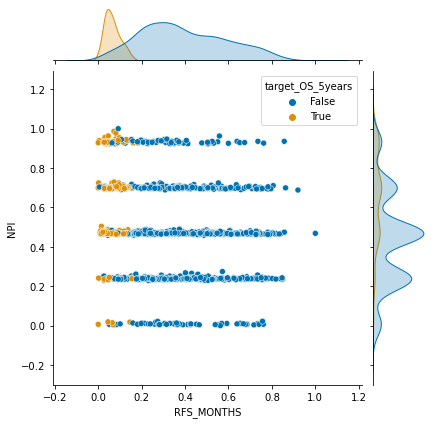

False    956
True     231
Name: target_OS_5years, dtype: int64

False    956
True     956
Name: target_OS_5years, dtype: int64

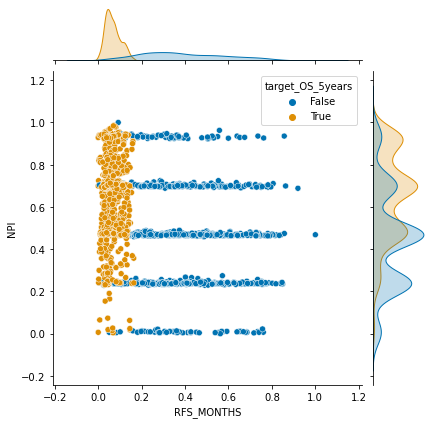

In [48]:
plot_columns = ["RFS_MONTHS", "NPI"]
# 目的変数の分布と２つの特徴量の可視化
sns_join_plot(X=X_train, y=y_train, plot_columns=plot_columns, normalization=True)

# SMOTEによるオーバーサンプリング
sm = SMOTE(random_state=SEED)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

display(y_train.value_counts(), y_resampled.value_counts())
# SMOTE実施後の分布のプロット
sns_join_plot(
    X=X_resampled, y=y_resampled, plot_columns=plot_columns, normalization=True
)

In [49]:
X_train.head()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,GRADE,PR_STATUS,TMB_NONSYNONYMOUS,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,HORMONE_THERAPY,RADIO_THERAPY,RFS_STATUS,RFS_MONTHS,COHORT_2.0,COHORT_3.0,COHORT_4.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,...,INTCLUST_6,INTCLUST_7,INTCLUST_8,INTCLUST_9,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
996,3.0,4.050,3,0,1,62.11,2,0,1.307518,1,2,1,0,25.0,1,0,1,220.89,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
861,2.0,5.030,3,1,0,43.51,3,0,5.230071,0,2,0,0,15.0,0,1,1,23.09,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
530,1.0,5.034,3,1,0,44.94,3,0,3.922553,0,2,0,0,17.0,0,1,0,245.49,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
108,0.0,4.058,2,0,1,55.09,3,0,7.845106,1,2,1,0,29.0,0,0,1,72.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1266,0.0,3.080,3,0,1,62.29,2,1,26.150354,1,3,1,1,40.0,0,0,0,260.76,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


In [50]:
y_train.head()

996     False
861      True
530     False
108     False
1266    False
Name: target_OS_5years, dtype: bool

In [51]:
X_resampled.head()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,GRADE,PR_STATUS,TMB_NONSYNONYMOUS,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,HORMONE_THERAPY,RADIO_THERAPY,RFS_STATUS,RFS_MONTHS,COHORT_2.0,COHORT_3.0,COHORT_4.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,...,INTCLUST_6,INTCLUST_7,INTCLUST_8,INTCLUST_9,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
0,3.0,4.050,3,0,1,62.11,2,0,1.307518,1,2,1,0,25.0,1,0,1,220.89,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,2.0,5.030,3,1,0,43.51,3,0,5.230071,0,2,0,0,15.0,0,1,1,23.09,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
2,1.0,5.034,3,1,0,44.94,3,0,3.922553,0,2,0,0,17.0,0,1,0,245.49,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,0.0,4.058,2,0,1,55.09,3,0,7.845106,1,2,1,0,29.0,0,0,1,72.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
4,0.0,3.080,3,0,1,62.29,2,1,26.150354,1,3,1,1,40.0,0,0,0,260.76,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


In [52]:
y_resampled.head()

0    False
1     True
2    False
3    False
4    False
Name: target_OS_5years, dtype: bool

<AxesSubplot:xlabel='RFS_MONTHS', ylabel='NPI'>

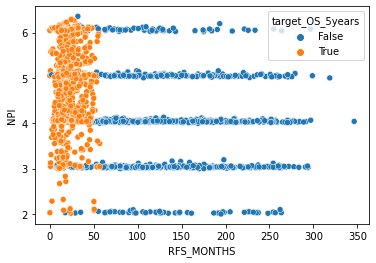

In [53]:
sns.scatterplot(x=X_resampled["RFS_MONTHS"], y=X_resampled["NPI"], hue=y_resampled)

# 生存曲線の観察

lifelinesというライブラリがあったので、試してみる。
https://lifelines.readthedocs.io/en/latest/index.html

In [13]:
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [14]:
# PATIENT_IDにMBを含むデータのみ含むデータフレームを読み込み
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MB.shape

(1985, 36)

<AxesSubplot:xlabel='timeline'>

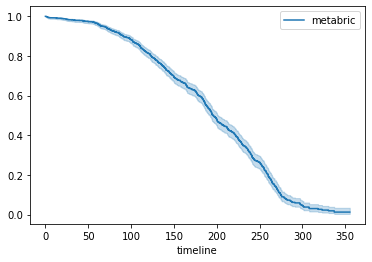

In [15]:
T = df_MB["OS_MONTHS"].dropna()
E = (
    df_MB["OS_STATUS"].dropna().map({"0:LIVING": 1, "1:DECEASED": 0})
)  # lifelinesを描くので、生存が1, 死亡が0

kmf = KaplanMeierFitter(label="metabric")
kmf.fit(T, E)
kmf.plot()